In [151]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
import torch
import sophius.dataload as dload
from sophius.modelgen import ConvModelGenerator
import torchvision.datasets as dset
import torchvision.transforms as T
from sophius.encode import Encoder
import seaborn as sns
from tqdm import tqdm
from sophius.train import train_on_gpu_ex
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),    
])
cifar10 = dset.CIFAR10('../data/CIFAR10', train=True, download=True, transform=normalize)
cifar_gpu = dload.cifar_to_gpu(cifar10)

encoder = Encoder()

Files already downloaded and verified


In [153]:
from sophius.estimate import LSTMRegressor
from sophius.utils import calc_model_flops

estimator = torch.load('../data/models/estimator_v2.pth').cpu()

def estimate_acc(model_tmpl):
    t = torch.tensor(encoder.model2vec(model_tmpl), dtype=torch.float32)
    return estimator(t).item()

Conv2d       (8, 32, 32)    (3, 3)   (1, 1)  
LeakyReLU    (8, 32, 32)    (0.01)  
BatchNorm2d  (8, 32, 32)   
AvgPool2d    (8, 31, 31)    (2, 2)   (1, 1)  
Flatten      7688          
Linear       10            

0.61 MFlops


Loss 37.144: 100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


val_acc: 0.552 train_acc: 0.667
val_acc* 0.562


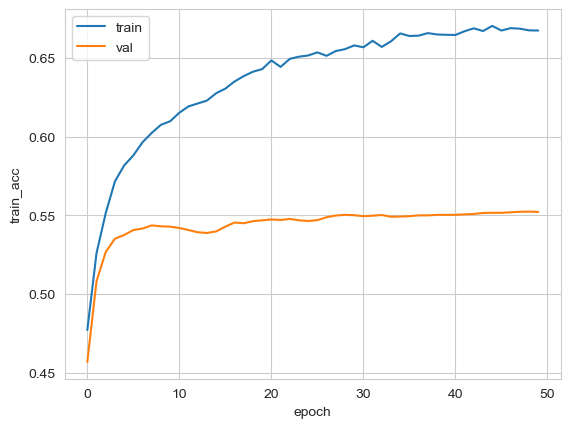

In [154]:
model_gen = ConvModelGenerator(
    in_shape=(3, 32, 32), 
    out_shape=10, 
    conv_num=1, 
    lin_num=1,
)

model_tmpl = model_gen.generate_model_tmpl()
model = model_tmpl.instantiate_model().cuda()

print(model_tmpl)
flops = calc_model_flops(model, model_gen.in_shape)['flops']
print(round(flops / 1024 / 1024, 2), 'MFlops')

train_params = {
    'val_size': 10000,
    'batch_size': 1024,
    'num_epoch': 5,
    'random_seed':42,
    'optimizer': 'AdamW',
    'opt_params': {
        'lr': 1e-3,
    },
    'scheduler': 'ExponentialLR',
    'sch_params': {
        'gamma': 0.95,
    },
}

res = train_on_gpu_ex(
    model=model,
    dataset=cifar_gpu,
    verbose=True,
    **train_params,
)
print('val_acc* %.3f' % (estimate_acc(model_tmpl)))

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val');

In [155]:
import torch
torch.cuda.get_device_name()

'NVIDIA RTX A500 Laptop GPU'

In [156]:
from sophius.db import *
from peewee import *

with database:
    database.create_tables([Experiments, Models, Devices, Runs, ModelEpochs])    

In [157]:
exp_params = {**train_params, **{'in_shape': (3, 32, 32), 'out_shape': 10}}

exp, _ = Experiments.get_or_create(**exp_params)
    
Devices.create_table()
dev, _ = Devices.get_or_create(name=torch.cuda.get_device_name())

In [158]:
model_gen = ConvModelGenerator(
    in_shape=(3, 32, 32), out_shape=10, 
    conv_num=1, lin_num=1
)

val_acc_threshold = 0.05

for i in tqdm(range(5)):
    model_tmpl = model_gen.generate_model_tmpl()
    model_gpu = model_tmpl.instantiate_model().cuda()
    
    if estimate_acc(model_tmpl) < val_acc_threshold:
        continue
    
    model_info = calc_model_flops(model_gpu, model_gen.in_shape)        
    model, _ = Models.get_or_create(
        hash = encoder.model2hash(model_tmpl),
        flops = model_info['flops'],
        macs = model_info['macs'],
        params = model_info['params'],
    )
        
    epoch_results = train_on_gpu_ex(
        model=model_gpu,
        dataset=cifar_gpu,
        verbose=False,
        **train_params,
    )
    
    run = Runs.create(
        exp_id = exp.id,
        model_id = model.id,
        device_id = dev.id,
        val_acc = epoch_results.val_acc.iloc[-10:].mean(),
        train_acc = epoch_results.train_acc.iloc[-10:],
        time = epoch_results.time.iloc[-1],
    )    
    
    for _, row in epoch_results.iterrows():
        ModelEpochs.create(
            run_id = run.id,
            loss = row['loss'],
            train_acc = row['train_acc'],
            val_acc = row['val_acc'],
            time = row['time'],
        )    

  0%|          | 0/5 [03:27<?, ?it/s]


KeyboardInterrupt: 

In [5]:
from sophius.db import *
from peewee import *
import pandas as pd

query = (Runs
         .select(Runs.id.alias('run_id'), Runs, Models, Devices.name.alias('dev_name'))
         .join(Models)
         .switch(Runs)
         .join(Devices)
         .dicts())

cols = ['run_id', 'hash', 'flops', 'params', 'val_acc', 'train_acc', 'time', 'dev_name']
df = pd.DataFrame(query)[cols]
df.time = df.time.round()

# df = pd.DataFrame(query)

df[-5:]

,run_id,hash,flops,params,val_acc,train_acc,time,dev_name
8526,8527,008020a208080000008401212000000000492000400000...,225058112,1675738,0.751863,0.999599,181.0,NVIDIA GeForce RTX 4090
8527,8528,0080842108040000004310000080441208040000002530...,90942048,399508,0.748187,0.858253,79.0,NVIDIA GeForce RTX 4090
8528,8529,0080208a10080000002328000081022220000000004920...,72814848,405691,0.681320,0.969111,54.0,NVIDIA GeForce RTX 4090
8529,8530,00810112200000000044a0004000000000802422080400...,16736000,118091,0.736849,0.841316,26.0,NVIDIA GeForce RTX 4090
8530,8531,00808122100200000022c8000080841210020000008082...,60098624,346091,0.753656,0.995683,55.0,NVIDIA GeForce RTX 4090


In [6]:
with database.connection() as conn:
    exp = pd.read_sql('SELECT * from experiments', conn)
exp

,id,val_size,batch_size,num_epoch,random_seed,optimizer,opt_params,scheduler,sch_params,in_shape,out_shape
0,1,10000,256,50,42,AdamW,"{""lr"":0.001}",ExponentialLR,"{""gamma"":0.95}","(3, 32, 32)",10


In [8]:
from sophius.encode import Encoder

encoder = Encoder()
encoder.hash2model('00810112200000000044a000400000000080242208040000400000000010000001000000', (3, 32, 32), 10)

C:\Users\alexander.korolyov\miniforge3\envs\sophius\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Conv2d       (64, 16, 16)   (5, 5)   (2, 2)  
ReLU         (64, 16, 16)  
MaxPool2d    (64, 8, 8)     (3, 3)   (2, 2)  
BatchNorm2d  (64, 8, 8)    
Conv2d       (192, 8, 8)    (3, 3)   (1, 1)  
PReLU        (192, 8, 8)   
BatchNorm2d  (192, 8, 8)   
GlobalAvgPool2d (192, 1, 1)   
Flatten      192           
Linear       10            